<a href="https://colab.research.google.com/github/vggls/medical_xai/blob/main/experiments/breakhis_resnet50/misclassified_HA_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Imports**

In [ ]:
pip install grad-cam

In [ ]:
import matplotlib.pyplot as plt

import torch
from torchvision  import datasets, transforms

from pytorch_grad_cam import GradCAM, HiResCAM

In [ ]:
# custom written code
from breakhis_slide_allocation import allocate_slides_to_datasets
from breakhis_binary import create_datasets, summaries
from haas import HA_image
from plot_tensor import convert_for_plot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Download from Kaggle**

In [ ]:
! mkdir ~/.kaggle/
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download ambarish/breakhis

100% 3.98G/3.99G [02:05<00:00, 35.3MB/s]
100% 3.99G/3.99G [02:05<00:00, 34.2MB/s]


In [ ]:
! unzip breakhis.zip

# **3. Test dataset**

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])
# to be applied to validation and test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])

In [ ]:
training_dataset, validation_dataset, test_dataset = create_datasets(train_transforms, test_transforms)

No benign slides overlap in training, validation and test sets!
No malignant slides overlap in training, validation and test sets!


In [ ]:
test_dataset.class_to_idx

{'benign': 0, 'malignant': 1}

# **4. ResNet50 - HA images**

In [ ]:
drive_path = './drive/MyDrive/Colab_Notebooks/dataset_models/BreakHis/Models/'
resnet50 = torch.load(drive_path + 'breakhis_resnet50.pt')
resnet50 = resnet50.eval()

In [ ]:
gradcam_instance = GradCAM(model=resnet50, target_layers=[resnet50.layer4[2].conv3], use_cuda=True)
hirescam_instance = HiResCAM(model=resnet50, target_layers=[resnet50.layer4[2].conv3], use_cuda=True)

In [ ]:
unfreeze = [resnet50.conv1, resnet50.bn1, resnet50.layer1, resnet50.layer2, resnet50.layer3, resnet50.layer4]
for child in unfreeze:
    for param in child.parameters():
        param.requires_grad = True

In [ ]:
#@title function

def breakhis_misclassified_ha_images(class_label, num_examples):

  i = 0
  for tensor,label in test_dataset:
    tensor = tensor.cuda()

    if (label==class_label and label == int(torch.argmax(resnet50(tensor.unsqueeze(0))))):

      plt.figure()
      fig, ax = plt.subplots(1, 5, figsize=(15,3))

      ax[0].imshow(convert_for_plot(tensor))
      ax[0].set_title('pred: {}'.format( list(test_dataset.class_to_idx.keys())[label])); ax[0].axis('off')

      gradcam_attributions = gradcam_instance(tensor.unsqueeze(0))[0,:,:]
      hirescam_attributions = hirescam_instance(tensor.unsqueeze(0))[0,:,:]

      ha_gradcam_tensor = HA_image(tensor, gradcam_attributions)
      ha_hirescam_tensor = HA_image(tensor, hirescam_attributions)

      gradcam_pred = int(torch.argmax(resnet50(ha_gradcam_tensor.unsqueeze(0))))
      hirescam_pred = int(torch.argmax(resnet50(ha_hirescam_tensor.unsqueeze(0))))

      if (label != gradcam_pred) and (label != hirescam_pred):

        i+=1

        gradcam_class = list(test_dataset.class_to_idx.keys())[gradcam_pred]
        hirescam_class = list(test_dataset.class_to_idx.keys())[hirescam_pred]

        ax[1].imshow(gradcam_attributions); ax[1].set_title('Grad-CAM Attributions'); ax[1].axis('off')

        ax[2].imshow(convert_for_plot(ha_gradcam_tensor)); ax[2].set_title('Grad-CAM HA image \n pred: {}'.format(gradcam_class)); ax[2].axis('off')

        ax[3].imshow(hirescam_attributions); ax[3].set_title('HiResCAM Attributions'); ax[3].axis('off')

        ax[4].imshow(convert_for_plot(ha_hirescam_tensor)); ax[4].set_title('HiResCAM HA image \n pred: {}'.format(hirescam_class)); ax[4].axis('off')

      else:
        plt.close(fig)

      if i==num_examples:
        break

<ipython-input-14-126fd9dccda6>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 5, figsize=(15,3))
<ipython-input-14-126fd9dccda6>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

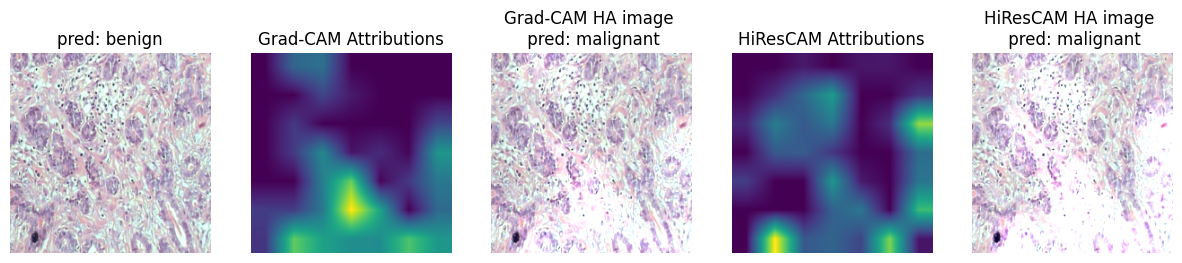

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

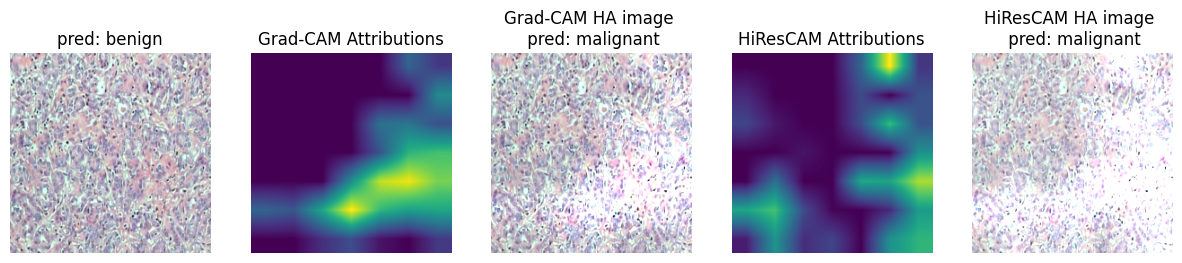

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

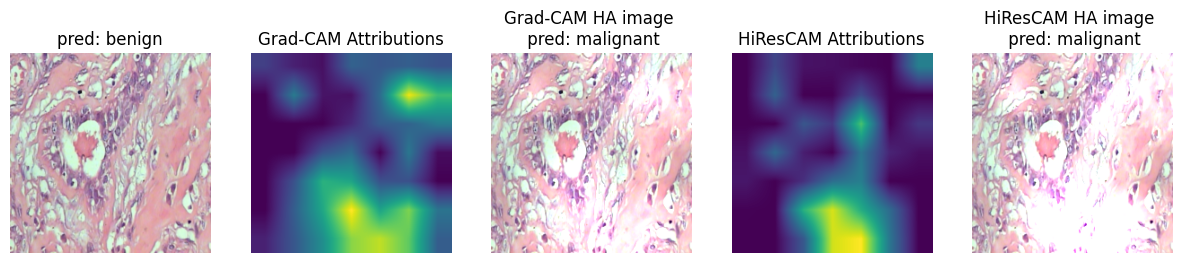

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

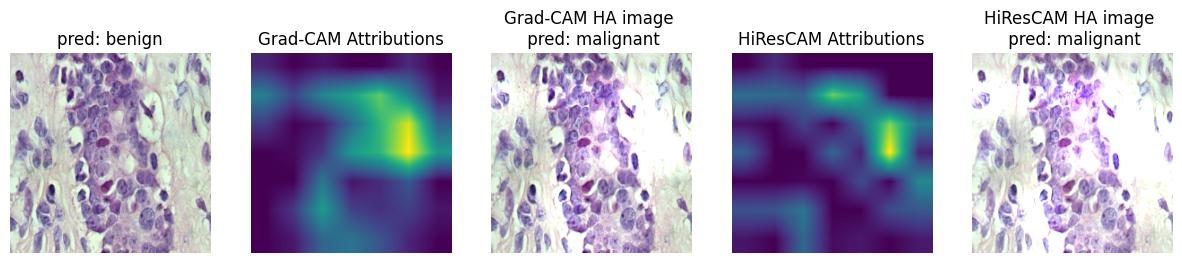

<Figure size 640x480 with 0 Axes>

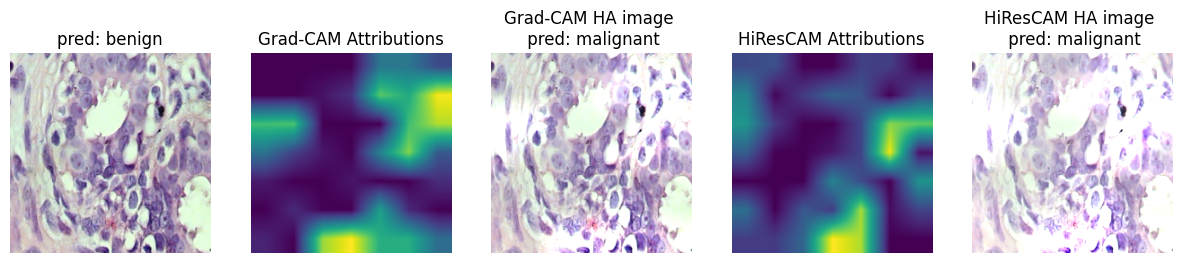

<Figure size 640x480 with 0 Axes>

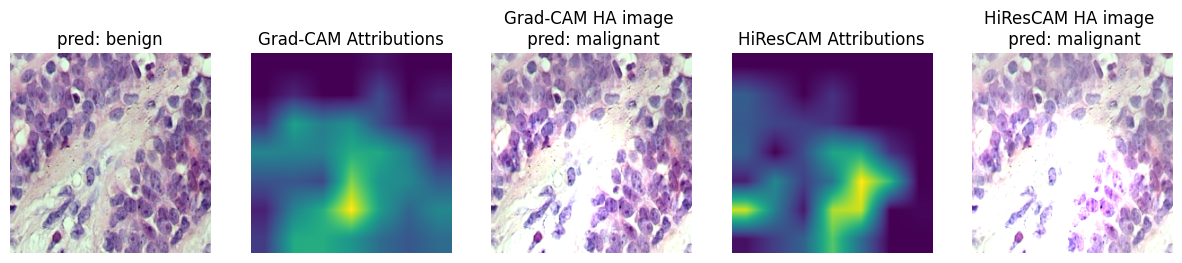

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

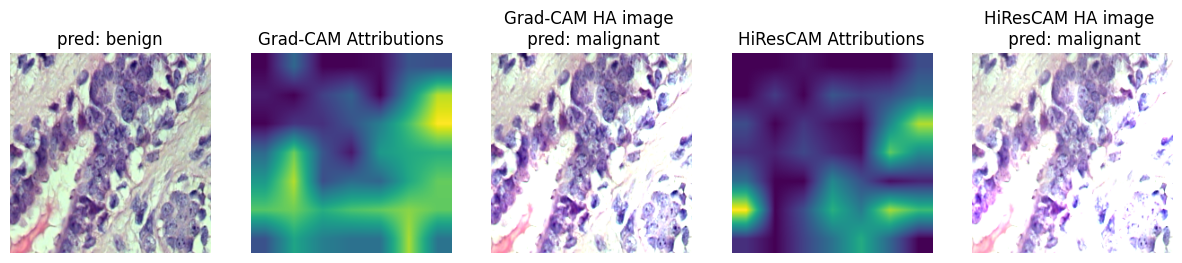

<Figure size 640x480 with 0 Axes>

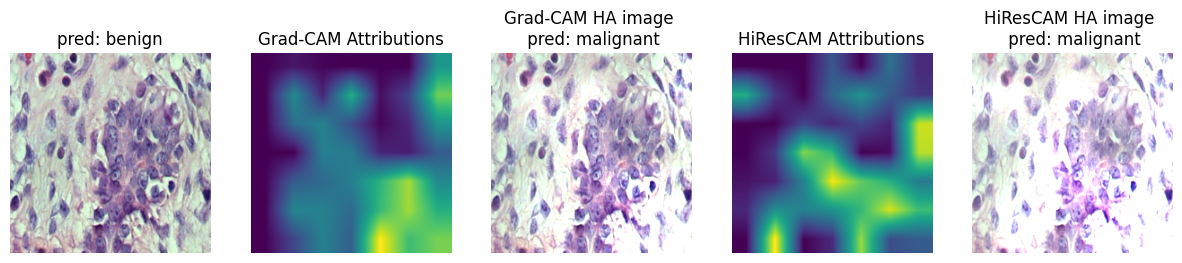

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

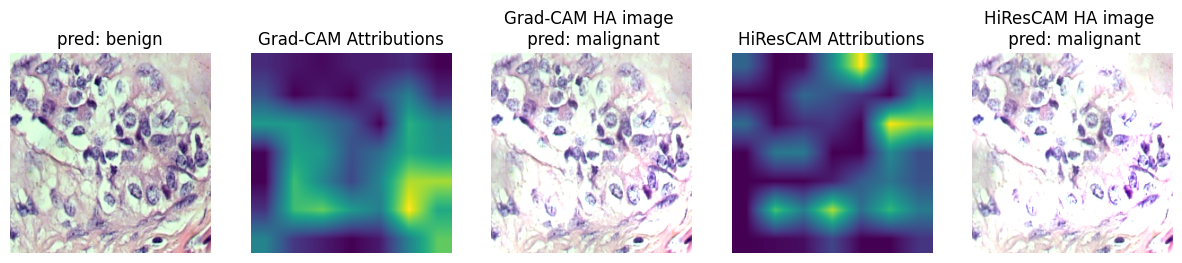

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

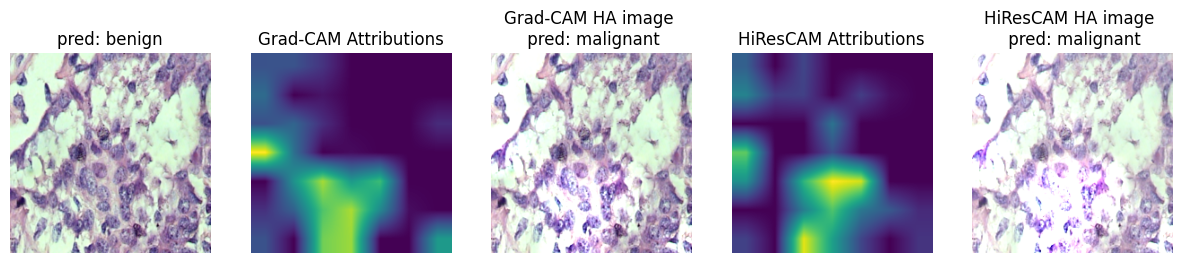

In [ ]:
breakhis_misclassified_ha_images(0, 10)

<ipython-input-14-126fd9dccda6>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

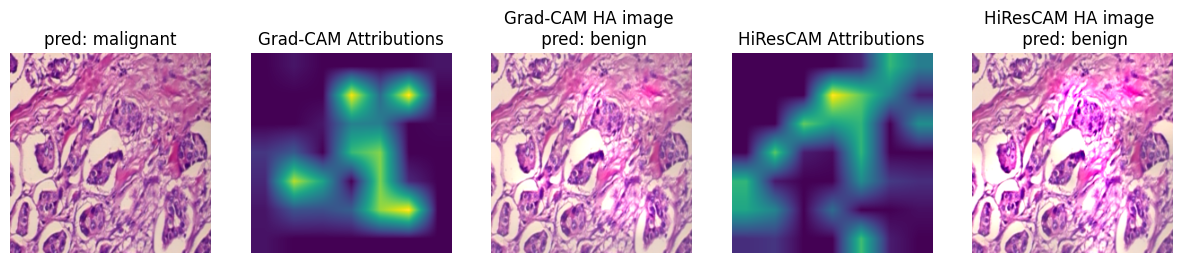

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

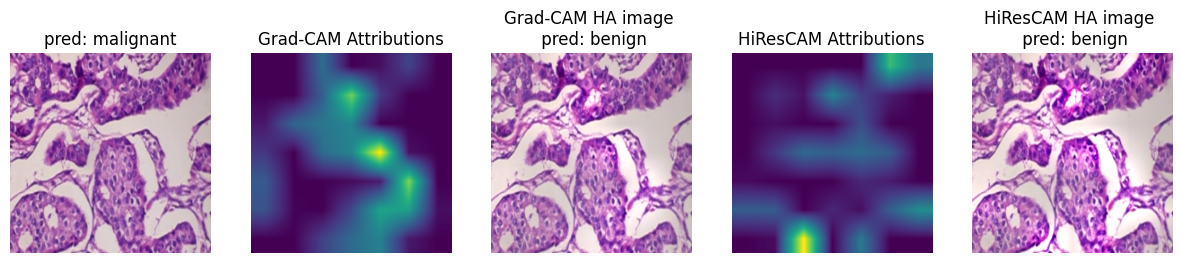

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

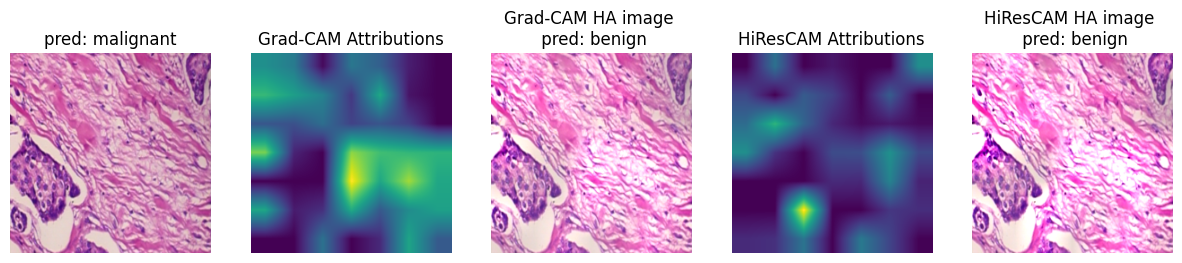

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

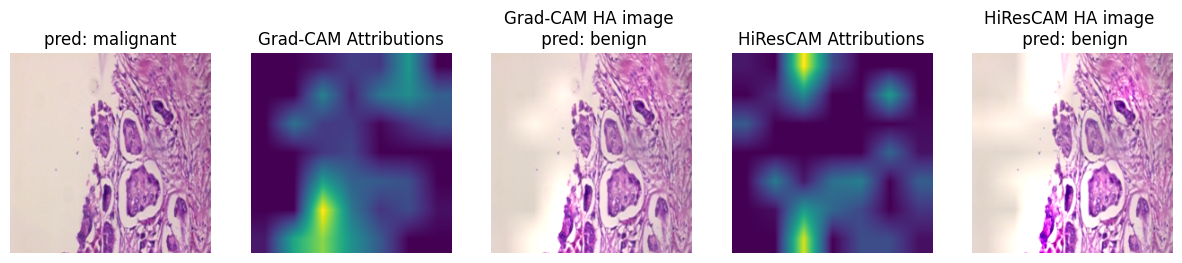

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

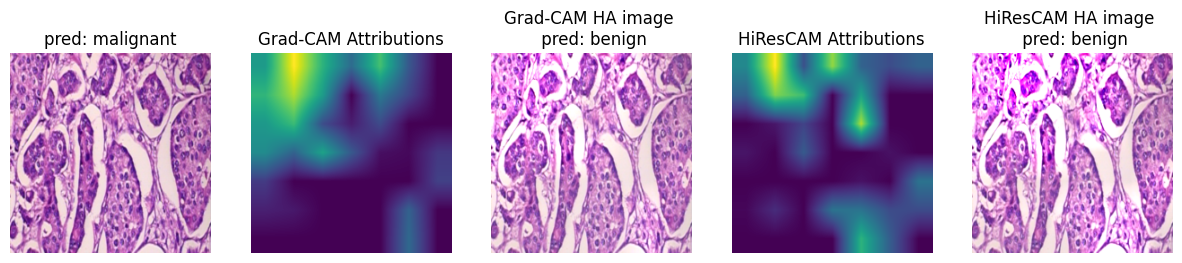

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

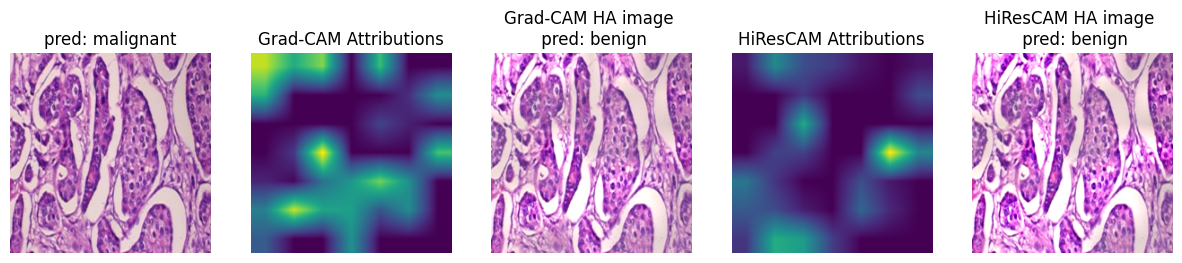

<Figure size 640x480 with 0 Axes>

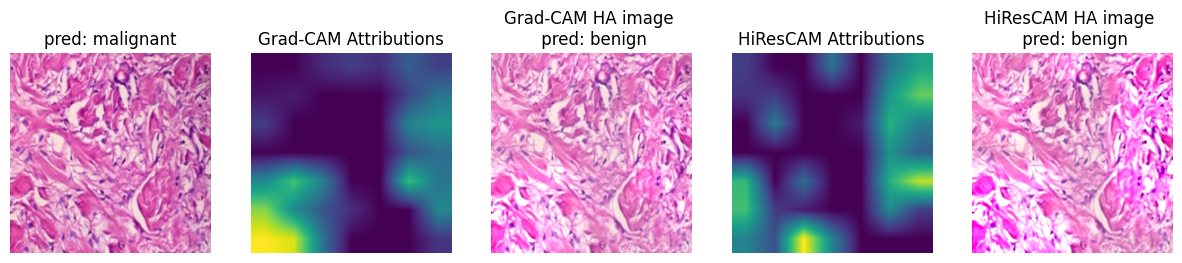

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

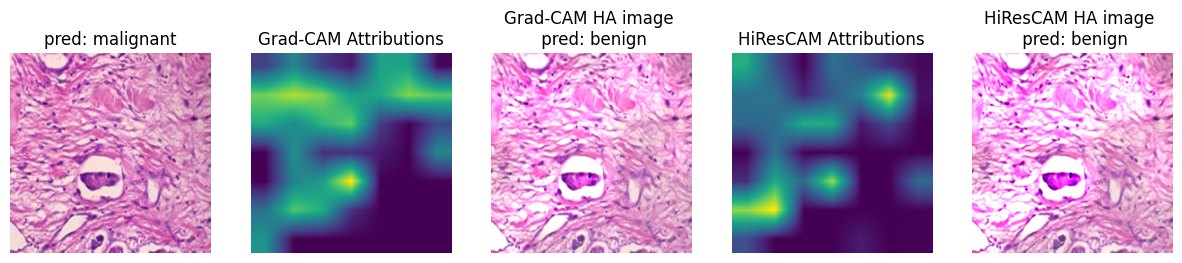

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

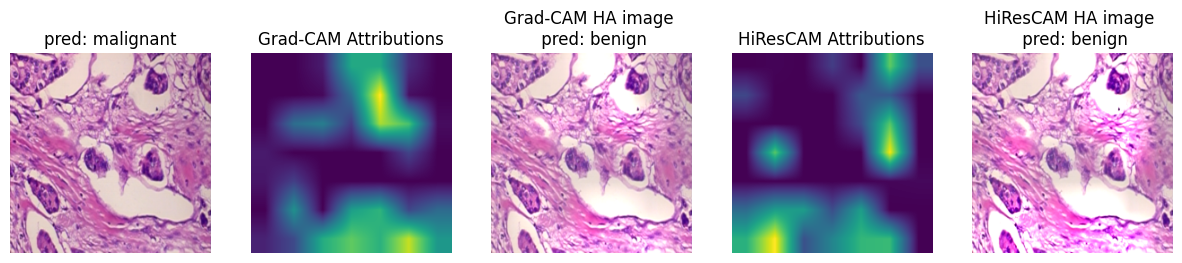

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

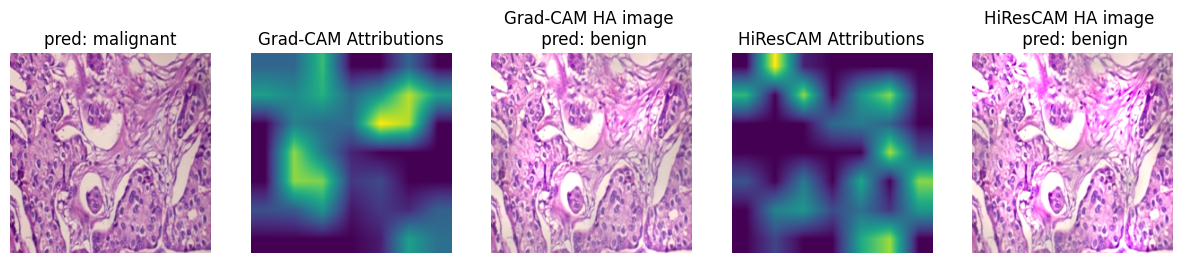

In [ ]:
breakhis_misclassified_ha_images(1, 10)